# LLM Text Generation: Understanding the Process

This notebook demonstrates the step-by-step process of how Large Language Models (LLMs) generate text. We'll use GPT-2, a small transformer model, to understand:

1. How models tokenize input text
2. What the raw model output looks like
3. How to extract and select the next token
4. How to generate text token by token

## Setup and Installation

In [1]:
!pip install -q transformers torch


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

## Load GPT-2 Model and Tokenizer

We'll use the smallest GPT-2 model (124M parameters) from HuggingFace.

In [3]:
# Load pre-trained model and tokenizer
model_name = "gpt2"  # This is the smallest GPT-2 model
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()

print(f"Model loaded: {model_name}")
print(f"Vocabulary size: {len(tokenizer)}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded: gpt2
Vocabulary size: 50257


In [4]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Step 1: Tokenization

Let's start with a story prompt and see how it gets tokenized.

In [5]:
# Our starting prompt
prompt = "Once upon a time in a distant"

# Tokenize the input
input_ids = tokenizer.encode(prompt, return_tensors="pt")

print(f"Prompt: '{prompt}'")
print(f"\nToken IDs: {input_ids[0].tolist()}")
print(f"Number of tokens: {len(input_ids[0])}")

# Show each token
print("\nToken breakdown:")
for i, token_id in enumerate(input_ids[0]):
    token_text = tokenizer.decode([token_id])
    print(f"  Token {i}: ID={token_id:5d} -> '{token_text}'")

Prompt: 'Once upon a time in a distant'

Token IDs: [7454, 2402, 257, 640, 287, 257, 12899]
Number of tokens: 7

Token breakdown:
  Token 0: ID= 7454 -> 'Once'
  Token 1: ID= 2402 -> ' upon'
  Token 2: ID=  257 -> ' a'
  Token 3: ID=  640 -> ' time'
  Token 4: ID=  287 -> ' in'
  Token 5: ID=  257 -> ' a'
  Token 6: ID=12899 -> ' distant'


In [6]:
input_ids

tensor([[ 7454,  2402,   257,   640,   287,   257, 12899]])

## Step 2: Get Raw Model Output

Now let's pass the tokens through the model and examine the raw output.

**Key Concept:** The model outputs a tensor of shape `[batch_size, sequence_length, vocab_size]` containing logits (unnormalized scores) for each possible next token.

In [7]:
# Get model output
with torch.no_grad():
    outputs = model(input_ids)
    
# The logits are the raw scores for each token in the vocabulary
logits = outputs.logits

print(f"Output shape: {logits.shape}")
print(f"  - Batch size: {logits.shape[0]}")
print(f"  - Sequence length: {logits.shape[1]}")
print(f"  - Vocabulary size: {logits.shape[2]}")

# We only care about the logits for the last token (predicting the next word)
next_token_logits = logits[0, -1, :]
print(f"\nNext token logits shape: {next_token_logits.shape}")
print(f"\nFirst 10 raw logit values: {next_token_logits[:10].tolist()}")

Output shape: torch.Size([1, 7, 50257])
  - Batch size: 1
  - Sequence length: 7
  - Vocabulary size: 50257

Next token logits shape: torch.Size([50257])

First 10 raw logit values: [-100.52684020996094, -98.48580169677734, -105.69713592529297, -103.90271759033203, -103.19029998779297, -103.01126098632812, -98.25801849365234, -100.1230697631836, -98.6717758178711, -101.82698059082031]


## Step 3: Understanding Logits

Logits are unnormalized scores. Let's examine them more closely.

In [8]:
print(f"Logits statistics:")
print(f"  Min logit: {next_token_logits.min().item():.2f}")
print(f"  Max logit: {next_token_logits.max().item():.2f}")
print(f"  Mean logit: {next_token_logits.mean().item():.2f}")
print(f"  Std logit: {next_token_logits.std().item():.2f}")

Logits statistics:
  Min logit: -120.79
  Max logit: -88.59
  Mean logit: -104.88
  Std logit: 4.16


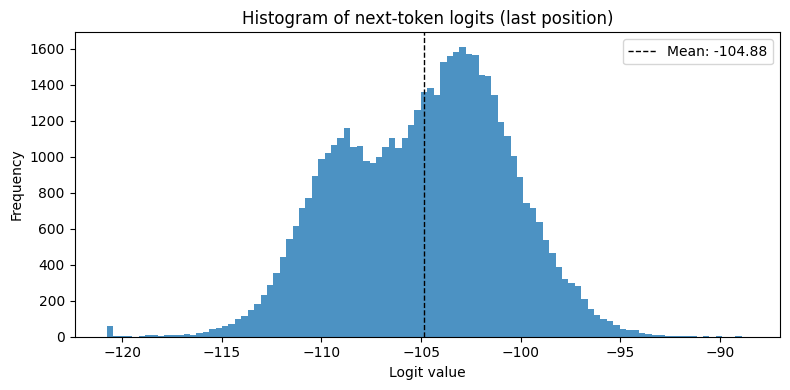

In [ ]:
# Plot a histogram of the next-token logits
import matplotlib.pyplot as plt

# Convert logits to numpy (handles CPU/GPU tensors)
logits_np = next_token_logits.detach().cpu().numpy()

plt.figure(figsize=(8,4))
# Use normalized counts (density) and log-scale for the y-axis
plt.hist(logits_np, bins=100, color='C0', alpha=0.8, density=True, log=True)
plt.axvline(logits_np.mean(), color='k', linestyle='dashed', linewidth=1, label=f'Mean: {logits_np.mean():.2f}')
plt.xlabel('Logit value')
plt.ylabel('Normalized frequency (density)')
plt.title('Histogram of next-token logits (last position) — density, log-scale')
plt.legend()
plt.tight_layout()
plt.show()

## Step 4: Convert Logits to Probabilities

To interpret these scores as probabilities, we apply the softmax function.

In [10]:
# Apply softmax to convert logits to probabilities
probabilities = torch.softmax(next_token_logits, dim=-1)

print(f"Probabilities shape: {probabilities.shape}")
print(f"Sum of probabilities: {probabilities.sum().item():.6f}")
print(f"\nFirst 10 probability values: {probabilities[:10].tolist()}")

Probabilities shape: torch.Size([50257])
Sum of probabilities: 1.000010

First 10 probability values: [1.0761143585114041e-06, 8.284574505523778e-06, 6.115437489739861e-09, 3.679031834735724e-08, 7.501231635842487e-08, 8.971978360250432e-08, 1.0403877240605652e-05, 1.6114383925014408e-06, 6.878641670482466e-06, 2.932342226813489e-07]


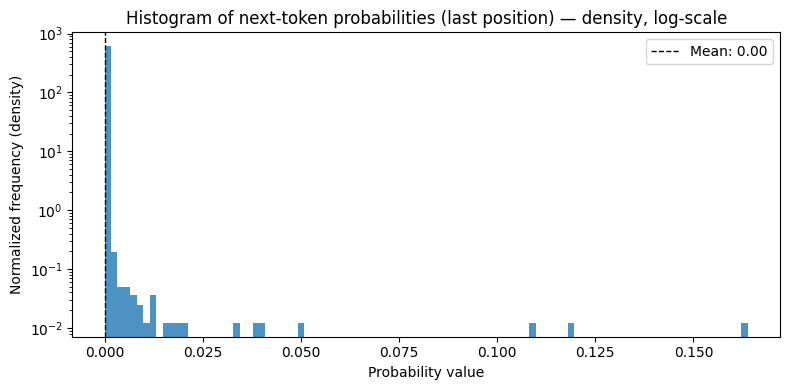

In [12]:
# Convert logits to numpy (handles CPU/GPU tensors)
prob_np = probabilities.detach().cpu().numpy()

plt.figure(figsize=(8,4))
# Use normalized counts (density) and log-scale for the y-axis
plt.hist(prob_np, bins=100, color='C0', alpha=0.8, density=True, log=True)
plt.axvline(prob_np.mean(), color='k', linestyle='dashed', linewidth=1, label=f'Mean: {prob_np.mean():.2f}')
plt.xlabel('Probability value')
plt.ylabel('Normalized frequency (density)')
plt.title('Histogram of next-token probabilities (last position) — density, log-scale')
plt.legend()
plt.tight_layout()
plt.show()

## Step 5: Extract the Top Tokens

Let's see which tokens have the highest probabilities.

In [13]:
# Get top 10 tokens
top_k = 10
top_probs, top_indices = torch.topk(probabilities, top_k)

print(f"Top {top_k} most likely next tokens:\n")
for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
    token_text = tokenizer.decode([idx])
    print(f"  {i+1}. '{token_text}' (ID: {idx.item()}) - Probability: {prob.item():.4f} ({prob.item()*100:.2f}%)")

Top 10 most likely next tokens:

  1. ' future' (ID: 2003) - Probability: 0.1639 (16.39%)
  2. ' land' (ID: 1956) - Probability: 0.1185 (11.85%)
  3. ' galaxy' (ID: 16161) - Probability: 0.1085 (10.85%)
  4. ' past' (ID: 1613) - Probability: 0.0494 (4.94%)
  5. ' place' (ID: 1295) - Probability: 0.0396 (3.96%)
  6. ' world' (ID: 995) - Probability: 0.0385 (3.85%)
  7. ' time' (ID: 640) - Probability: 0.0342 (3.42%)
  8. ' corner' (ID: 5228) - Probability: 0.0200 (2.00%)
  9. ' space' (ID: 2272) - Probability: 0.0192 (1.92%)
  10. ',' (ID: 11) - Probability: 0.0180 (1.80%)


## Exercise 1: Extract the Best Token

**Your Task:** Write code to extract the single most likely next token from the model output.

Hints:
- You can use `torch.argmax()` to find the index of the maximum value
- Use `tokenizer.decode()` to convert the token ID back to text

In [ ]:
# TODO: Write code to extract the best (most likely) next token
# Your code here:

best_token_id = None  # Replace with your code
best_token_text = None  # Replace with your code

print(f"Best next token: '{best_token_text}' (ID: {best_token_id})")

### Solution for Exercise 1

In [8]:
# Solution
best_token_id = torch.argmax(probabilities).item()
best_token_text = tokenizer.decode([best_token_id])

print(f"Best next token: '{best_token_text}' (ID: {best_token_id})")
print(f"Probability: {probabilities[best_token_id].item():.4f}")

Best next token: ' future' (ID: 2003)
Probability: 0.1639


## Step 6: Greedy Decoding - Generate Multiple Tokens

Now let's generate a full sentence by repeatedly selecting the best token (greedy decoding).

In [15]:
def generate_text_greedy(prompt, max_length=20):
    """
    Generate text using greedy decoding (always select the most likely token)
    """
    # Tokenize input
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    print(f"Starting prompt: '{prompt}'")
    print(f"Generating {max_length} tokens...\n")
    
    generated_tokens = []
    
    for step in range(max_length):
        # Get model output
        with torch.no_grad():
            outputs = model(input_ids)
            next_token_logits = outputs.logits[0, -1, :]
        
        # Get probabilities
        probabilities = torch.softmax(next_token_logits, dim=-1)
        
        # Select the most likely token
        next_token_id = torch.argmax(probabilities).item()
        next_token_text = tokenizer.decode([next_token_id])
        
        # Print step-by-step generation
        print(f"Step {step+1}: '{next_token_text}' (prob: {probabilities[next_token_id].item():.4f})")
        
        generated_tokens.append(next_token_id)
        
        # Add the generated token to input for next iteration
        input_ids = torch.cat([input_ids, torch.tensor([[next_token_id]])], dim=-1)
    
    # Decode the full generated sequence
    full_text = tokenizer.decode(input_ids[0])
    return full_text

# Generate text
result = generate_text_greedy("Once upon a time in a distant", max_length=15)
print(f"\n{'='*60}")
print(f"Final generated text:\n{result}")

Starting prompt: 'Once upon a time in a distant'
Generating 15 tokens...

Step 1: ' future' (prob: 0.1639)
Step 2: ',' (prob: 0.6390)
Step 3: ' the' (prob: 0.1520)
Step 4: ' world' (prob: 0.0421)
Step 5: ' was' (prob: 0.1780)
Step 6: ' a' (prob: 0.0659)
Step 7: ' place' (prob: 0.0594)
Step 8: ' of' (prob: 0.5240)
Step 9: ' great' (prob: 0.0372)
Step 10: ' beauty' (prob: 0.0609)
Step 11: ' and' (prob: 0.4223)
Step 12: ' great' (prob: 0.0739)
Step 13: ' danger' (prob: 0.1127)
Step 14: '.' (prob: 0.5765)
Step 15: ' The' (prob: 0.1227)

Final generated text:
Once upon a time in a distant future, the world was a place of great beauty and great danger. The


## Step 7: Different Sampling Strategies

Greedy decoding always picks the most likely token, which can lead to repetitive text. Let's explore other strategies.

### 7.1 Temperature Sampling

Temperature controls the randomness:
- Low temperature (< 1.0): More confident, deterministic
- High temperature (> 1.0): More random, creative

In [10]:
def apply_temperature(logits, temperature=1.0):
    """
    Apply temperature scaling to logits
    """
    return logits / temperature

# Compare different temperatures
temperatures = [0.5, 1.0, 2.0]

print("Effect of temperature on token probabilities:\n")
for temp in temperatures:
    scaled_logits = apply_temperature(next_token_logits, temp)
    probs = torch.softmax(scaled_logits, dim=-1)
    top_probs, top_indices = torch.topk(probs, 5)
    
    print(f"Temperature = {temp}")
    for prob, idx in zip(top_probs, top_indices):
        token = tokenizer.decode([idx])
        print(f"  '{token}': {prob.item():.4f}")
    print()

Effect of temperature on token probabilities:

Temperature = 0.5
  ' future': 0.4339
  ' land': 0.2270
  ' galaxy': 0.1901
  ' past': 0.0394
  ' place': 0.0254

Temperature = 1.0
  ' future': 0.1639
  ' land': 0.1185
  ' galaxy': 0.1085
  ' past': 0.0494
  ' place': 0.0396

Temperature = 2.0
  ' future': 0.0105
  ' land': 0.0089
  ' galaxy': 0.0085
  ' past': 0.0057
  ' place': 0.0051



## Exercise 2: Implement Temperature Sampling

**Your Task:** Modify the generation function to use temperature sampling instead of greedy decoding.

Steps:
1. Apply temperature scaling to the logits
2. Convert to probabilities with softmax
3. Sample from the probability distribution using `torch.multinomial()`

In [ ]:
def generate_text_with_temperature(prompt, max_length=20, temperature=1.0):
    """
    Generate text using temperature sampling
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    for step in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            next_token_logits = outputs.logits[0, -1, :]
        
        # TODO: Apply temperature and sample
        # Your code here:
        
        # 1. Apply temperature
        scaled_logits = None  # Replace with your code
        
        # 2. Get probabilities
        probabilities = None  # Replace with your code
        
        # 3. Sample from distribution
        next_token_id = None  # Replace with your code (use torch.multinomial)
        
        input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=-1)
    
    return tokenizer.decode(input_ids[0])

# Test with different temperatures
print("Greedy (temp=0.1):")
print(generate_text_with_temperature("Once upon a time", max_length=15, temperature=0.1))
print("\nBalanced (temp=1.0):")
print(generate_text_with_temperature("Once upon a time", max_length=15, temperature=1.0))
print("\nCreative (temp=1.5):")
print(generate_text_with_temperature("Once upon a time", max_length=15, temperature=1.5))

### Solution for Exercise 2

In [17]:
def generate_text_with_temperature(prompt, max_length=20, temperature=1.0):
    """
    Generate text using temperature sampling - SOLUTION
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    for step in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            next_token_logits = outputs.logits[0, -1, :]
        
        # Apply temperature
        scaled_logits = next_token_logits / temperature
        
        # Get probabilities
        probabilities = torch.softmax(scaled_logits, dim=-1)
        
        # Sample from distribution
        next_token_id = torch.multinomial(probabilities, num_samples=1)
        
        input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=-1)
    
    return tokenizer.decode(input_ids[0])

# Test with different temperatures
print("Greedy (temp=0.1):")
print(generate_text_with_temperature("Once upon a time", max_length=15, temperature=0.1))
print("\nBalanced (temp=1.0):")
print(generate_text_with_temperature("Once upon a time", max_length=15, temperature=1.0))
print("\nCreative (temp=1.5):")
print(generate_text_with_temperature("Once upon a time", max_length=15, temperature=1.5))

Greedy (temp=0.1):
Once upon a time, the world was a place of chaos and chaos. The world was a

Balanced (temp=1.0):
Once upon a time her head and shoulders gave shape to a very familiar face, a slightly bo

Creative (temp=1.5):
Once upon a time was called drew Kou pouring out flesh, lodging while waking night Sounders small capsules


## Step 8: Top-k Sampling

Top-k sampling only considers the k most likely tokens.

In [18]:
def generate_text_top_k(prompt, max_length=20, temperature=1.0, top_k=50):
    """
    Generate text using top-k sampling
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    for step in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            next_token_logits = outputs.logits[0, -1, :]
        
        # Apply temperature
        scaled_logits = next_token_logits / temperature
        
        # Get top-k logits
        top_k_logits, top_k_indices = torch.topk(scaled_logits, top_k)
        
        # Get probabilities only for top-k
        top_k_probs = torch.softmax(top_k_logits, dim=-1)
        
        # Sample from top-k
        sampled_index = torch.multinomial(top_k_probs, num_samples=1)
        next_token_id = top_k_indices[sampled_index]
        
        input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=-1)
    
    return tokenizer.decode(input_ids[0])

print("Top-k sampling (k=10):")
print(generate_text_top_k("Once upon a time", max_length=20, temperature=0.8, top_k=10))
print("\nTop-k sampling (k=50):")
print(generate_text_top_k("Once upon a time", max_length=20, temperature=0.8, top_k=50))

Top-k sampling (k=10):
Once upon a time, I have had to make a decision about where to go. It's been a long time since

Top-k sampling (k=50):
Once upon a time when so many people were seeking a world where the sun never set, the moon never came, and


## Summary

In this notebook, you learned:

1. **Tokenization**: How text is converted to token IDs
2. **Model Output**: The model produces logits (unnormalized scores) for every token in the vocabulary
3. **Probabilities**: Logits are converted to probabilities using softmax
4. **Token Selection**: Different strategies for selecting the next token:
   - **Greedy**: Always pick the most likely token
   - **Temperature Sampling**: Control randomness with temperature
   - **Top-k Sampling**: Sample from the k most likely tokens

### Key Takeaways:
- LLMs generate text one token at a time
- The model outputs a probability distribution over all possible next tokens
- Different sampling strategies trade off between quality and diversity

## Bonus Exercise: Compare All Methods

Generate the same story beginning with all three methods and compare the results!

In [13]:
prompt = "In a world where dragons still existed,"

print("=" * 60)
print("Greedy Decoding:")
print("=" * 60)
print(generate_text_greedy(prompt, max_length=25))

print("\n" + "=" * 60)
print("Temperature Sampling (temp=0.8):")
print("=" * 60)
print(generate_text_with_temperature(prompt, max_length=25, temperature=0.8))

print("\n" + "=" * 60)
print("Top-k Sampling (k=50, temp=0.8):")
print("=" * 60)
print(generate_text_top_k(prompt, max_length=25, temperature=0.8, top_k=50))

Greedy Decoding:
Starting prompt: 'In a world where dragons still existed,'
Generating 25 tokens...

Step 1: ' the' (prob: 0.1028)
Step 2: ' dragon' (prob: 0.0205)
Step 3: ' was' (prob: 0.0638)
Step 4: ' a' (prob: 0.1217)
Step 5: ' symbol' (prob: 0.0363)
Step 6: ' of' (prob: 0.8414)
Step 7: ' power' (prob: 0.1195)
Step 8: ' and' (prob: 0.3137)
Step 9: ' power' (prob: 0.0732)
Step 10: 'lessness' (prob: 0.4622)
Step 11: '.' (prob: 0.6250)
Step 12: '
' (prob: 0.1486)
Step 13: '
' (prob: 0.9621)
Step 14: 'The' (prob: 0.0956)
Step 15: ' dragon' (prob: 0.1934)
Step 16: ' was' (prob: 0.2617)
Step 17: ' a' (prob: 0.1859)
Step 18: ' symbol' (prob: 0.2447)
Step 19: ' of' (prob: 0.9380)
Step 20: ' power' (prob: 0.1057)
Step 21: ' and' (prob: 0.4528)
Step 22: ' power' (prob: 0.5776)
Step 23: 'lessness' (prob: 0.9973)
Step 24: '.' (prob: 0.7717)
Step 25: '
' (prob: 0.5058)
In a world where dragons still existed, the dragon was a symbol of power and powerlessness.

The dragon was a symbol of power a

---

# Follow-Up Exercises: Beginner Level

Now that you understand the basics of text generation, try these exercises to deepen your understanding!

## Exercise 3: Top-p (Nucleus) Sampling

**Difficulty:** Beginner

**Objective:** Implement top-p (nucleus) sampling, a more dynamic alternative to top-k sampling.

### What is Top-p Sampling?

Instead of selecting a fixed number of tokens (like top-k), top-p sampling selects the smallest set of tokens whose cumulative probability exceeds a threshold `p`.

**Example:** If p=0.9, select the minimum number of tokens that together have 90% probability.

### Why is this useful?
- **Dynamic selection**: Sometimes the model is very confident (few tokens needed), sometimes uncertain (many tokens needed)
- **Better quality**: Avoids sampling very unlikely tokens while maintaining diversity
- **Widely used**: This is the default in many modern LLM APIs (GPT-3, GPT-4, etc.)

### Your Task:

Complete the function below to implement top-p sampling.

**Steps:**
1. Apply temperature scaling to logits
2. Convert to probabilities using softmax
3. Sort probabilities in descending order
4. Calculate cumulative sum of sorted probabilities
5. Find where cumulative sum exceeds p
6. Keep only those tokens and sample from them

**Hints:**
- Use `torch.sort()` to sort probabilities (set `descending=True`)
- Use `torch.cumsum()` to calculate cumulative sum
- Use boolean indexing to filter tokens: `probs[cumsum <= p]`
- Don't forget to renormalize probabilities after filtering!

In [ ]:
def generate_text_top_p(prompt, max_length=20, temperature=1.0, top_p=0.9):
    """
    Generate text using top-p (nucleus) sampling
    
    Args:
        prompt: Starting text
        max_length: Number of tokens to generate
        temperature: Sampling temperature
        top_p: Cumulative probability threshold (0.0 to 1.0)
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    for step in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            next_token_logits = outputs.logits[0, -1, :]
        
        # TODO: Implement top-p sampling
        # Your code here:
        
        # 1. Apply temperature
        scaled_logits = None  # Your code
        
        # 2. Get probabilities
        probabilities = None  # Your code
        
        # 3. Sort probabilities in descending order
        sorted_probs, sorted_indices = None, None  # Your code (use torch.sort)
        
        # 4. Calculate cumulative sum
        cumsum_probs = None  # Your code (use torch.cumsum)
        
        # 5. Find tokens to keep (where cumsum <= top_p)
        # Add at least one token to handle edge case
        keep_mask = None  # Your code
        
        # 6. Filter and renormalize probabilities
        filtered_probs = None  # Your code
        filtered_indices = None  # Your code
        
        # Renormalize
        filtered_probs = filtered_probs / filtered_probs.sum()
        
        # 7. Sample from filtered distribution
        sampled_index = torch.multinomial(filtered_probs, num_samples=1)
        next_token_id = filtered_indices[sampled_index]
        
        input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=-1)
    
    return tokenizer.decode(input_ids[0])

# Test your implementation
print("Top-p sampling (p=0.5 - conservative):")
print(generate_text_top_p("Once upon a time", max_length=20, temperature=0.8, top_p=0.5))
print("\nTop-p sampling (p=0.9 - balanced):")
print(generate_text_top_p("Once upon a time", max_length=20, temperature=0.8, top_p=0.9))
print("\nTop-p sampling (p=0.95 - creative):")
print(generate_text_top_p("Once upon a time", max_length=20, temperature=0.8, top_p=0.95))

### Solution for Exercise 3

In [ ]:
def generate_text_top_p(prompt, max_length=20, temperature=1.0, top_p=0.9):
    """
    Generate text using top-p (nucleus) sampling - SOLUTION
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    for step in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            next_token_logits = outputs.logits[0, -1, :]
        
        # Apply temperature
        scaled_logits = next_token_logits / temperature
        
        # Get probabilities
        probabilities = torch.softmax(scaled_logits, dim=-1)
        
        # Sort probabilities in descending order
        sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)
        
        # Calculate cumulative sum
        cumsum_probs = torch.cumsum(sorted_probs, dim=-1)
        
        # Find tokens to keep (where cumsum <= top_p)
        # We keep at least one token (the highest probability one)
        keep_mask = cumsum_probs <= top_p
        # Ensure at least one token is kept
        keep_mask[0] = True
        
        # Filter probabilities and indices
        filtered_probs = sorted_probs[keep_mask]
        filtered_indices = sorted_indices[keep_mask]
        
        # Renormalize
        filtered_probs = filtered_probs / filtered_probs.sum()
        
        # Sample from filtered distribution
        sampled_index = torch.multinomial(filtered_probs, num_samples=1)
        next_token_id = filtered_indices[sampled_index]
        
        input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=-1)
    
    return tokenizer.decode(input_ids[0])

# Test
print("Top-p sampling (p=0.5):")
print(generate_text_top_p("Once upon a time", max_length=20, temperature=0.8, top_p=0.5))
print("\nTop-p sampling (p=0.9):")
print(generate_text_top_p("Once upon a time", max_length=20, temperature=0.8, top_p=0.9))
print("\nTop-p sampling (p=0.95):")
print(generate_text_top_p("Once upon a time", max_length=20, temperature=0.8, top_p=0.95))

## Exercise 4: Implementing Stopping Criteria

**Difficulty:** Beginner

**Objective:** Add intelligent stopping conditions to text generation instead of always generating a fixed number of tokens.

### Why Stopping Criteria?

In real applications, you don't want to generate exactly N tokens. You want to stop when:
- An end-of-sequence (EOS) token is generated
- A complete sentence is finished (ending with `.`, `!`, or `?`)
- A maximum length is reached (safety limit)

### Your Task:

Modify the generation function to support multiple stopping conditions.

**Requirements:**
1. Stop if EOS token is generated (check `tokenizer.eos_token_id`)
2. Stop if a sentence-ending punctuation is generated (`.`, `!`, `?`)
3. Stop if max_length is reached
4. Return the generated text and the reason for stopping

**Hints:**
- Use `tokenizer.eos_token_id` to get the EOS token ID
- Use `tokenizer.decode([token_id])` to check if a token is punctuation
- Keep track of which stopping condition was met

In [ ]:
def generate_with_stopping(prompt, max_length=50, temperature=0.8, stop_on_sentence=True):
    """
    Generate text with intelligent stopping criteria
    
    Args:
        prompt: Starting text
        max_length: Maximum tokens to generate
        temperature: Sampling temperature
        stop_on_sentence: Whether to stop at sentence endings
    
    Returns:
        tuple: (generated_text, stop_reason)
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    # TODO: Implement stopping criteria
    # Your code here:
    
    for step in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            next_token_logits = outputs.logits[0, -1, :]
        
        # Sample next token (using temperature sampling)
        scaled_logits = next_token_logits / temperature
        probabilities = torch.softmax(scaled_logits, dim=-1)
        next_token_id = torch.multinomial(probabilities, num_samples=1)
        
        # Add to sequence
        input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=-1)
        
        # TODO: Check stopping conditions
        
        # 1. Check if EOS token
        if None:  # Your code
            return tokenizer.decode(input_ids[0]), "EOS token"
        
        # 2. Check if sentence-ending punctuation
        if stop_on_sentence:
            token_text = None  # Your code: decode the token
            if None:  # Your code: check if token is '.', '!', or '?'
                return tokenizer.decode(input_ids[0]), "Sentence ending"
    
    # 3. Reached max length
    return tokenizer.decode(input_ids[0]), "Max length"

# Test your implementation
prompts = [
    "The secret to happiness is",
    "In the beginning",
    "Scientists discovered that"
]

for prompt in prompts:
    text, reason = generate_with_stopping(prompt, max_length=30, temperature=0.8)
    print(f"Prompt: '{prompt}'")
    print(f"Generated: {text}")
    print(f"Stopped because: {reason}")
    print("-" * 60)

### Solution for Exercise 4

In [ ]:
def generate_with_stopping(prompt, max_length=50, temperature=0.8, stop_on_sentence=True):
    """
    Generate text with intelligent stopping criteria - SOLUTION
    """
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    for step in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            next_token_logits = outputs.logits[0, -1, :]
        
        # Sample next token
        scaled_logits = next_token_logits / temperature
        probabilities = torch.softmax(scaled_logits, dim=-1)
        next_token_id = torch.multinomial(probabilities, num_samples=1)
        
        # Add to sequence
        input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=-1)
        
        # Check stopping conditions
        
        # 1. Check if EOS token
        if next_token_id.item() == tokenizer.eos_token_id:
            return tokenizer.decode(input_ids[0]), "EOS token"
        
        # 2. Check if sentence-ending punctuation
        if stop_on_sentence:
            token_text = tokenizer.decode([next_token_id.item()])
            if token_text.strip() in ['.', '!', '?']:
                return tokenizer.decode(input_ids[0]), "Sentence ending"
    
    # 3. Reached max length
    return tokenizer.decode(input_ids[0]), "Max length"

# Test
prompts = [
    "The secret to happiness is",
    "In the beginning",
    "Scientists discovered that"
]

for prompt in prompts:
    text, reason = generate_with_stopping(prompt, max_length=30, temperature=0.8)
    print(f"Prompt: '{prompt}'")
    print(f"Generated: {text}")
    print(f"Stopped because: {reason}")
    print("-" * 60)

## Exercise 5: Batch Text Generation

**Difficulty:** Beginner

**Objective:** Generate multiple different continuations from the same prompt in parallel.

### Why Batch Generation?

In many applications, you want to:
- Generate multiple story variations
- Compare different outputs and select the best one
- Show users multiple options to choose from
- Improve efficiency by processing in parallel

### Your Task:

Create a function that generates N different continuations from the same prompt.

**Requirements:**
1. Generate `num_samples` different continuations
2. Each continuation should use temperature sampling for diversity
3. Set different random seeds for each sample (or just rely on sampling randomness)
4. Return a list of all generated texts

**Challenge:** Can you make this more efficient by using batch processing?

**Hints:**
- Simple approach: Loop N times and generate each sample independently
- Advanced approach: Use batch dimension in tensors (replicate input_ids N times)

In [ ]:
def generate_multiple_samples(prompt, num_samples=5, max_length=20, temperature=1.0):
    """
    Generate multiple different continuations from the same prompt
    
    Args:
        prompt: Starting text
        num_samples: Number of different continuations to generate
        max_length: Tokens to generate per sample
        temperature: Sampling temperature
    
    Returns:
        list: List of generated texts
    """
    # TODO: Generate num_samples different continuations
    # Your code here:
    
    samples = []
    
    for i in range(num_samples):
        # Generate one sample
        generated_text = None  # Your code: use generate_text_with_temperature or similar
        samples.append(generated_text)
    
    return samples

# Test your implementation
prompt = "The mysterious door opened to reveal"
samples = generate_multiple_samples(prompt, num_samples=5, max_length=15, temperature=1.2)

print(f"Prompt: '{prompt}'\n")
print("Generated continuations:\n")
for i, sample in enumerate(samples, 1):
    print(f"{i}. {sample}")
    print()

### Solution for Exercise 5

In [ ]:
def generate_multiple_samples(prompt, num_samples=5, max_length=20, temperature=1.0):
    """
    Generate multiple different continuations - SOLUTION
    """
    samples = []
    
    for i in range(num_samples):
        # Generate one sample using temperature sampling
        generated_text = generate_text_with_temperature(
            prompt, 
            max_length=max_length, 
            temperature=temperature
        )
        samples.append(generated_text)
    
    return samples

# Test
prompt = "The mysterious door opened to reveal"
samples = generate_multiple_samples(prompt, num_samples=5, max_length=15, temperature=1.2)

print(f"Prompt: '{prompt}'\n")
print("Generated continuations:\n")
for i, sample in enumerate(samples, 1):
    print(f"{i}. {sample}")
    print()

## Bonus Challenge: Compare Sampling Methods

Now that you've implemented all the sampling methods, create a comprehensive comparison:

1. Generate 10 continuations using each method (greedy, temperature, top-k, top-p)
2. For each method, calculate:
   - Average text length
   - Number of unique continuations
   - Diversity score (ratio of unique words to total words)
3. Visualize the results (optional: create bar charts)
4. Write a brief analysis of which method works best for different scenarios

**Think about:**
- Which method produces the most diverse outputs?
- Which method produces the most coherent outputs?
- Which method would you use for creative writing vs. factual completion?
- How do temperature and top-p interact?

In [ ]:
# Your analysis code here
# Feel free to be creative with your comparison!

## Next Steps

Congratulations on completing the beginner exercises! You now have a solid understanding of:
- Different sampling strategies (greedy, temperature, top-k, top-p)
- Stopping criteria for text generation
- Generating multiple samples for diversity

**Ready for more?** Try the intermediate exercises:
- Implement beam search
- Add repetition penalties
- Build an interactive storytelling application
- Experiment with different models and compare their outputs

**Remember:** Understanding how LLMs generate text token-by-token is fundamental to working with modern AI systems!